# EEG Classification Notebook with Kalman Filter

Here we classify the EEG signal using a CNN. To generate the ground truth labels, we apply a kalman filter to the feeltrace signal, and then generate the emotion labels from this new signal.

In [12]:
# import some useful libraries

import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from scipy import signal


# model creation
import torch.nn as nn
import torch.nn.functional as F
import torch

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold, KFold

# loading bar
from tqdm import tqdm

# kalman filter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter


## Load Dataset

In [13]:
dir = '../eeg_feeltrace' # directory containing *.csv files
# hyper parameters
window_size = 500 # must be an int in milliseconds
overlap = 0.7 # overlap %
subject_num = 16 # which subject to choose [1-16]
k_fold = 5 # k for k fold validation
apply_kf = True # apply kalman filter
label_type = 'angle' # 'angle' or 'pos' or 'both'
num_classes = 3 if label_type != 'both' else 9 # number of classes to discretize the labels into
num_features = 64 # eeg feature size
classifier_learning_rate = 1e-3 # adam learning rate
classifier_train_epochs = 10 # train classifier duration
classifier_hidden = 8 # classifier parameter, the larger the more complicated the model

In [14]:
# functions for preprocessing dataset
# The features are 5x64x64 images (Channel,Height,Width)

def load_dataset(dir = 'feeltrace', subject_num = 5):
    # choose the subject
    subject_data_files = glob.glob(os.path.join(dir, 'eeg_ft_*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.csv')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    eeg_ft = subject_data_files[subject_num-1]

    print(f"Chosen subject: {eeg_ft}")
    
    data_signal = pd.read_csv(eeg_ft) # read the Nx(1+1+64) data for a single subject
    # return signal
    return data_signal

def generate_label(eeg_ft, split_size=100, k=5, label_type='angle', num_classes=3, kf=False, overlap=0.0):

    # split into windows (with overlap %)
    dataset = [eeg_ft[x : x + split_size] for x in range(0, len(eeg_ft), int(split_size * (1.0-overlap)))]
    dataset = [x for x in dataset if len(x) == split_size] # remove last windows if they are smaller than the rest

    if label_type != 'both':
        labels, raw_label = get_label(dataset, n_labels=num_classes, label_type=label_type, kf=kf, dt=split_size/1000) # (N, 1)
    else:
        labels, raw_label = get_combined_label(dataset, n_labels=int(np.sqrt(num_classes))) # (N, 1)

    dataset = generate_eeg_features(dataset)
    dataset = np.vstack([np.expand_dims(x,0) for x in dataset]) # (N, eeg_feature_size, 64)

    print(f"EEG feature shape (N, freq_bands, channels, channels):  {dataset.shape}")
    print(f"label set shape (N,):  {labels.shape}")

    indices = split_dataset(labels, k=k) # split data into train/test indices using kFold validation
    return dataset, labels, indices, raw_label


def apply_kalman(raw_label, dt=1e-3, R=1e2, var=1e2, p=1e2):
    kf = KalmanFilter(dim_x=2, dim_z=1)

    kf.x = np.array([[0.5],
                [0.]])       # initial state (location and angle)

    kf.F = np.array([[1.,dt],
                [0.,1.]])    # state transition matrix

    kf.H = np.array([[1.,1.]])    # Measurement function
    kf.P = np.array([[p,    0.],
                [   0., p] ])               # covariance matrix
    kf.R = R                      # state uncertainty
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=var) # process uncertainty

    kf_signal = np.zeros_like(raw_label)
    for i,m in enumerate(raw_label):
        kf.predict() # predict
        kf.update(m) # measure
        x = np.clip(kf.x[0], 0,1)
        kf_signal[i] = x
    return kf_signal


def get_label(data, n_labels=3, label_type='angle', kf=False, dt=1e-3):
    if label_type == 'angle':
        labels = stress_2_angle(np.vstack([x[:,1].T for x in data])) # angle/slope mapped to [0,1] in a time window
    elif label_type == 'pos':
        labels = np.vstack([x[:,1].mean() for x in data]) # mean value within the time window
    else:
        labels = stress_2_accumulator(np.vstack([x[:,1].T for x in data])) # accumulator mapped to [0,1] in a time window

    if kf:
        labels = apply_kalman(labels, dt, R=1e3, var=1e3, p=1e3)
        
    label_dist = stress_2_label(labels, n_labels=n_labels).squeeze()
    return label_dist, labels.squeeze()

def get_combined_label(data, n_labels=3):
    angle_labels, _ = get_label(data, n_labels=n_labels, label_type='angle') # (N, 1)
    pos_labels, _ = get_label(data, n_labels=n_labels, label_type='pos') # (N, 1)

    labels = [x for x in range(n_labels)]
    labels_dict =  {(a, b) : n_labels*a+b for a in labels for b in labels} # cartesian product
    combined_labels = [labels_dict[(pos, angle)] for (pos, angle) in zip(pos_labels, angle_labels)]
    return np.array(combined_labels)


def stress_2_label(mean_stress, n_labels=5):
    # value is in [0,1] so map to [0,labels-1] and discretize
    return np.digitize(mean_stress * n_labels, np.arange(n_labels)) - 1

def stress_2_angle(stress_windows):
    '''
    do a linear least squares fit in the time window
    stress_window: (N_samples, time_window)
    '''
    xvals = np.arange(stress_windows.shape[-1])/1e3/60 # time in (minutes)
    slope = np.polyfit(xvals, stress_windows.T, 1)[0] # take slope linear term # 1/s
    angle = np.arctan(slope)/ (np.pi/2) * 0.5 + 0.5 # map to [0,1]
    return angle

def stress_2_accumulator(stress_windows):
    '''
    apply an integral to the time window
    stress_window: (N_samples, time_window)
    '''
    max_area = stress_windows.shape[-1]
    xvals = np.arange(stress_windows.shape[-1]) # time in (ms)
    integral = np.trapz(stress_windows, x=xvals)
    return integral/max_area # map to [0,1]

def split_dataset(labels, k=5, strat=True):
    '''
    split the features and labels into k groups for k fold validation
    we use StratifiedKFold to ensure that the class distributions within each sample is the same as the global distribution
    '''
    if strat:
        kf = StratifiedKFold(n_splits=k, shuffle=True)
    else:
        kf = KFold(n_splits=k, shuffle=True)

    # only labels are required for generating the split indices so we ignore it
    temp_features = np.zeros_like(labels)
    indices = [(train_index, test_index) for train_index, test_index in kf.split(temp_features, labels)]
    return indices

def generate_eeg_features(dataset):
    sample_freq = 1000
    # get FFT
    psd_windows = [signal.periodogram(x[:,2:], sample_freq, window='hamming', axis=0) for x in dataset ] # get the power spectral density for each window

    # frequency bands
    bands={'alpha': (8, 12), 'beta': (12, 30), 'delta': (1, 4), 'theta': (4, 7), 'gamma': (30, 50)}
    chosen_bands = ['alpha', 'beta', 'delta', 'theta', 'gamma']
    band_freqs = [bands[x] for x in chosen_bands]

    features = []
    for window in psd_windows: # calculate the power in each band for channel for each window
        freqs, psd = window
        idx_bands = [np.logical_and(freqs >= low, freqs <= high) for low,high in band_freqs]

        freq_res = freqs[1] - freqs[0]
        band_powers = np.array([sp.integrate.simpson(psd[idx,:], dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
        total_powers = np.array([sp.integrate.simpson(psd, dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
        diff_entropy = -0.5 * np.log(band_powers/total_powers)
        # (5, 1, 64)
        # (5, 64, 1)
        diff_de = np.expand_dims(diff_entropy, axis=2) - np.expand_dims(diff_entropy, axis=1) # (5,64,64)
        diff_de = (diff_de  - diff_de.min(axis=(1,2), keepdims=True))/(diff_de.max(axis=(1,2), keepdims=True) - diff_de.min(axis=(1,2), keepdims=True))
        
        features.append(diff_de)
    return features

In [15]:
eeg_ft_signal = load_dataset(dir = dir, subject_num = subject_num)

Chosen subject: ../eeg_feeltrace/eeg_ft_15.csv


EEG feature shape (N, freq_bands, channels, channels):  (3337, 5, 64, 64)
label set shape (N,):  (3337,)
EEG feature shape (N, freq_bands, channels, channels):  (3337, 5, 64, 64)
label set shape (N,):  (3337,)
Label class bincount: [ 801 1878  658]


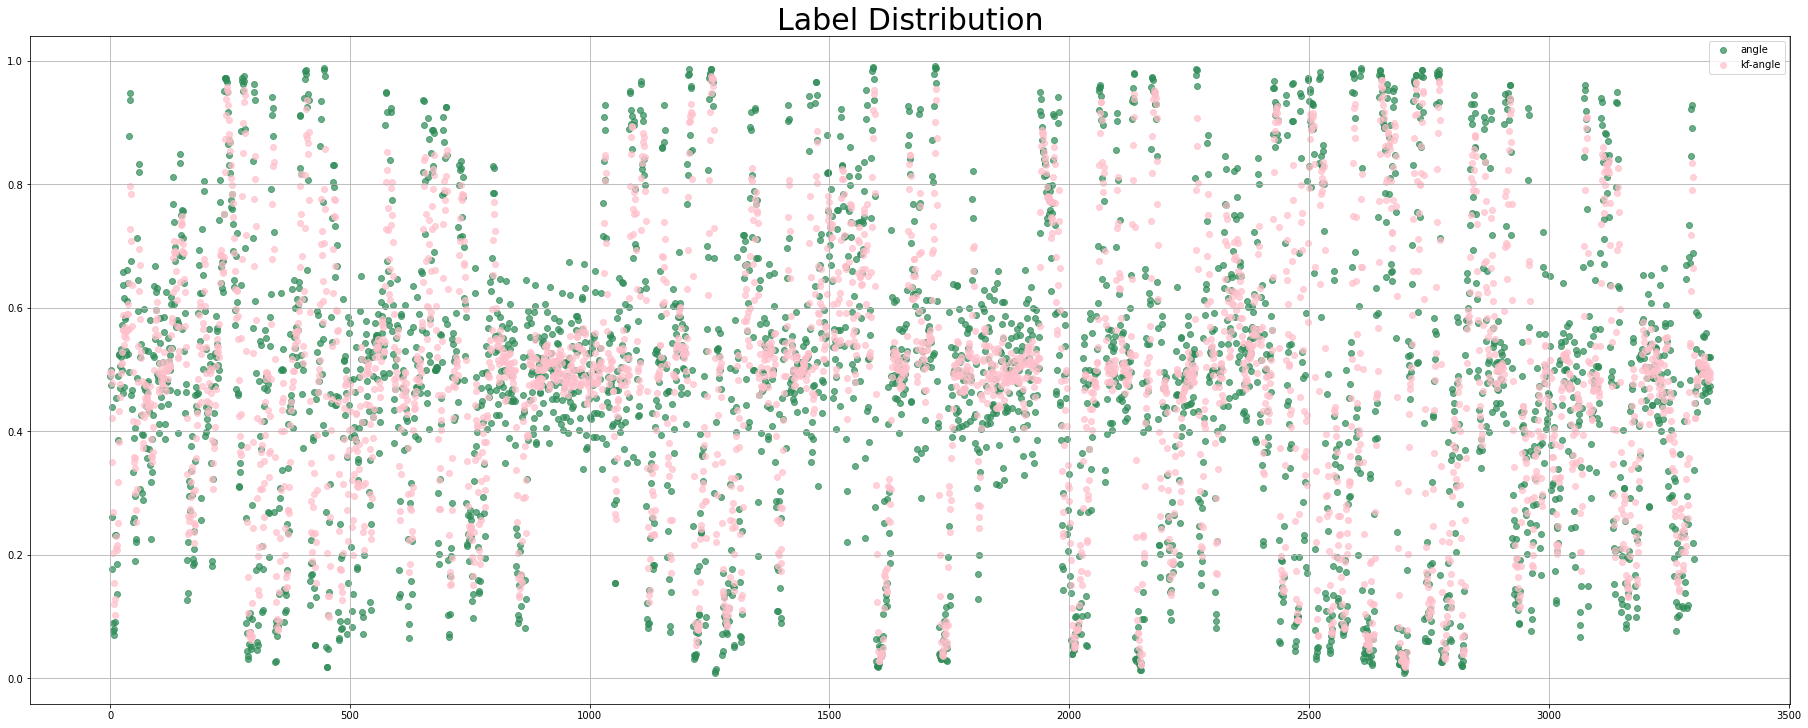

In [16]:
eeg_features, _, _, kf_raw_label = generate_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, label_type=label_type, num_classes=num_classes, kf=apply_kf, overlap=overlap)
_, labels, indices, raw_label = generate_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, label_type=label_type, num_classes=num_classes, kf=False, overlap=overlap)
print(f"Label class bincount: {np.bincount(labels, minlength=num_classes)}")


fsize = 30

fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
axes.scatter(np.arange(len(labels)), raw_label, alpha=0.7, color='seagreen', label=label_type)
axes.scatter(np.arange(len(labels)), kf_raw_label, alpha=0.7, color='pink', label='kf-'+label_type )
axes.grid('on', linestyle='-')
axes.set_aspect('auto')
axes.set_title('Label Distribution', fontsize=fsize)
axes.legend(loc='best')
plt.show()

In [83]:
# eeg_features, labels, indices, raw_label = generate_regression_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, kf=apply_kf)
# #print(f"Label class bincount: {np.bincount(labels, minlength=num_classes)}")


# fsize = 30

# fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
# axes.scatter(np.arange(len(labels)), raw_label[:,0], alpha=0.7, color='seagreen', label='position')
# axes.scatter(np.arange(len(labels)), labels[:,0], alpha=0.7, color='slateblue', label='kf-position')
# axes.grid('on', linestyle='-')
# axes.set_aspect('auto')
# axes.set_title('Label Distribution', fontsize=fsize)
# axes.legend(loc='best')
# plt.show()

# fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
# axes.scatter(np.arange(len(labels)), raw_label[:,1], alpha=0.7, color='pink', label='angle')
# axes.scatter(np.arange(len(labels)), labels[:,1], alpha=0.7, color='gray', label='kf-angle')
# axes.grid('on', linestyle='-')
# axes.set_aspect('auto')
# axes.set_title('Label Distribution', fontsize=fsize)
# axes.legend(loc='best')
# plt.show()



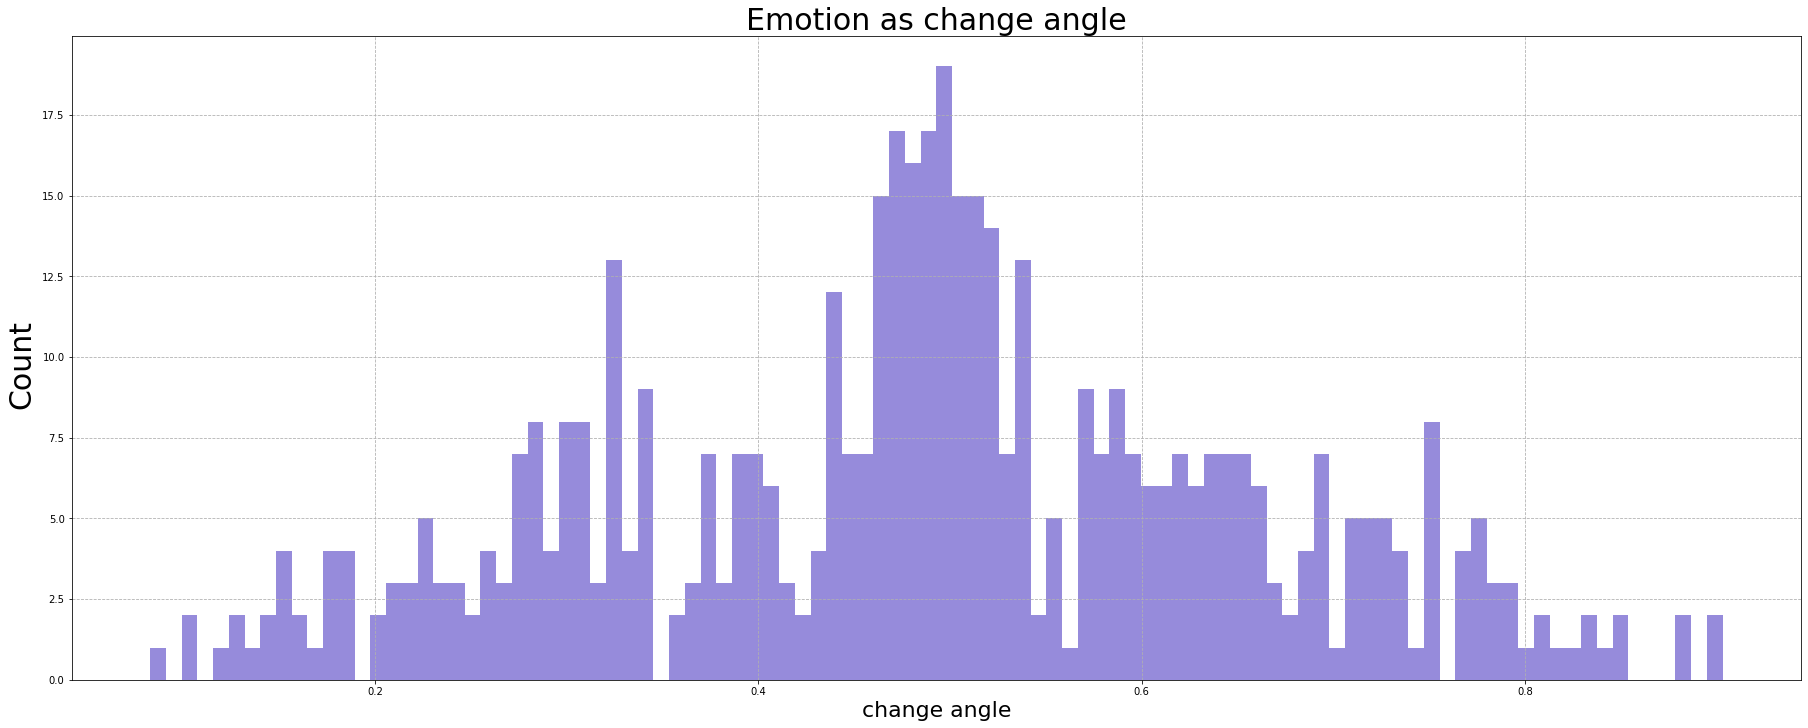

In [7]:
fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
n_bins = 100
fsize = 30
lsize = 22

axes.hist(kf_raw_label, histtype='stepfilled', alpha=0.7, bins=n_bins, color='slateblue', label='position')
axes.grid('on', linestyle='--')
axes.set_aspect('auto')
axes.set_title('Emotion as change angle', fontsize=fsize)
axes.set_xlabel('change angle', fontsize=lsize)


fig.supylabel('Count', fontsize=fsize)
plt.show()


In [1]:
# import seaborn as sns
# g = sns.pairplot(data=label_df[["kf_pos", "kf_angle", "kf_accumulator", "pos", "angle", "accumulator"]], corner=True)
# plt.show()
# del g

## EEG Classifier and Training Function

In [17]:
class classifier(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=5):
        super(classifier, self).__init__()
        
        self.hidden_size = num_hidden
        self.input_size = num_features
        self.n_classes = n_labels


        self.cnn = nn.Sequential(
            nn.Conv2d(5, 8, 3, padding='same', padding_mode='circular'),
            nn.ReLU()
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(64 * 64 * 8, self.n_classes))
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.classify(x) 
        return x

class regressor(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=2):
        super(regressor, self).__init__()
        
        self.hidden_size = num_hidden
        self.input_size = num_features
        self.n_classes = n_labels


        self.cnn = nn.Sequential(
            nn.Conv2d(5, 8, 3, padding='same'),
            nn.ReLU()
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(64 * 64 * 8, self.n_classes),
            nn.Sigmoid())
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.classify(x) 
        return x

class classifier_dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        'Initialization'
        self.x = features # (N, eeg_feature_size, 64)
        self.labels = labels # (N, 1)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = torch.from_numpy(self.x[index]).float() # (eeg_feature_size, 64, 64)
        y = torch.from_numpy(np.array(self.labels[index])).long() # feel trace labels int value [0,n_labels]
        return x, y


def train_classifier(model, num_epochs=5, batch_size=1, learning_rate=1e-3, features=None, labels=None,  label_smoothing=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    train_dataset = classifier_dataset(features, labels)
    
    # figure out class distribution to over sample less represented classes

    train_labels = labels
    
    # get the weights of each class as 1/occurrence
    train_class_weight = np.bincount(train_labels, minlength=num_classes)
    print(f"Train label distribution: {train_class_weight}")
    train_class_weight = 1/train_class_weight
    
    # get the per sample weight, which is the likelihood os sampling
    train_sample_weights = [train_class_weight[x] for x in train_labels]
    
    # sampler, weighted by the inverse of the occurrence
    train_sampler = torch.utils.data.WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)
    
        
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               sampler=train_sampler)
    
    train_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_acc = 0 # accuracy
        cur_train_pc = 0 # precision
        cur_train_rc = 0 # recall
        cur_train_f1 = 0 # f1
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            y_hat_np = F.softmax(y_hat.detach(), dim=1).argmax(axis=1).cpu().numpy().squeeze().reshape(-1,) # predictions
            y_np = y.detach().cpu().numpy().squeeze().reshape(-1,) # labels
            
            # metrics
            prf = precision_recall_fscore_support(y_np, y_hat_np, average='macro', zero_division=0)
            
            cur_train_acc += np.mean(y_hat_np == y_np)
            cur_train_pc += prf[0]
            cur_train_rc += prf[1]
            cur_train_f1 += prf[2]
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_acc  = cur_train_acc/train_loop_size
        cur_train_pc   = cur_train_pc/train_loop_size
        cur_train_rc   = cur_train_rc/train_loop_size
        cur_train_f1   = cur_train_f1/train_loop_size
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_acc, cur_train_pc, cur_train_rc, cur_train_f1, cur_train_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss},'\
              f'\nTrain Accuracy:{cur_train_acc},'\
              f'\nTrain Recall: {cur_train_rc},'\
              f'\nTrain precision: {cur_train_pc},' \
              f'\nTrain F1-Score:{cur_train_f1},')
        
    return train_metrics


def train_regressor(model, num_epochs=5, batch_size=1, learning_rate=1e-3, features=None, labels=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    criterion = nn.MSELoss()
    train_dataset = classifier_dataset(features, labels)
    
    # figure out class distribution to over sample less represented classes

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8)
    
    train_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
            # metrics
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss}')
        
    return train_metrics

## Training Classifier Loop

Training k=0
Training Classifier!
Train label distribution: [ 641 1502  526]


100%|██████████| 21/21 [00:03<00:00,  5.88it/s]


Epoch:1,
Train Loss:1.1005276441574097,
Train Accuracy:0.3797953527741372,
Train Recall: 0.3709064275781616,
Train precision: 0.36266311962391623,
Train F1-Score:0.30184311782357875,


100%|██████████| 21/21 [00:03<00:00,  6.07it/s]


Epoch:2,
Train Loss:1.0680415630340576,
Train Accuracy:0.4310697903014417,
Train Recall: 0.43426346732436455,
Train precision: 0.46224751199609915,
Train F1-Score:0.41243612506501326,


100%|██████████| 21/21 [00:03<00:00,  6.06it/s]


Epoch:3,
Train Loss:1.0307565927505493,
Train Accuracy:0.4630809032328528,
Train Recall: 0.4691684600083703,
Train precision: 0.4789179590164082,
Train F1-Score:0.45199837363511186,


100%|██████████| 21/21 [00:04<00:00,  5.17it/s]


Epoch:4,
Train Loss:1.0023778676986694,
Train Accuracy:0.49714667977282656,
Train Recall: 0.4987911082510172,
Train precision: 0.5013949006813141,
Train F1-Score:0.49107075518077264,


100%|██████████| 21/21 [00:03<00:00,  5.87it/s]


Epoch:5,
Train Loss:0.9852549433708191,
Train Accuracy:0.5109900611620796,
Train Recall: 0.5094140672162384,
Train precision: 0.5172812902177729,
Train F1-Score:0.5015714012088144,


100%|██████████| 21/21 [00:03<00:00,  5.95it/s]


Epoch:6,
Train Loss:0.9700227379798889,
Train Accuracy:0.5431957186544343,
Train Recall: 0.5450384834964431,
Train precision: 0.5549350185206257,
Train F1-Score:0.5389919238357399,


100%|██████████| 21/21 [00:03<00:00,  5.65it/s]


Epoch:7,
Train Loss:0.9532944560050964,
Train Accuracy:0.5481617245522061,
Train Recall: 0.5475073516442682,
Train precision: 0.5578015010830295,
Train F1-Score:0.5414959337651032,


100%|██████████| 21/21 [00:03<00:00,  5.26it/s]


Epoch:8,
Train Loss:0.9152629375457764,
Train Accuracy:0.5744798492791612,
Train Recall: 0.57303309587956,
Train precision: 0.5837097737140289,
Train F1-Score:0.5669112352752566,


100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Epoch:9,
Train Loss:0.9109377264976501,
Train Accuracy:0.5712272007426824,
Train Recall: 0.5730662815391491,
Train precision: 0.5796286700692246,
Train F1-Score:0.5665892934692665,


100%|██████████| 21/21 [00:03<00:00,  5.85it/s]


Epoch:10,
Train Loss:0.8959987163543701,
Train Accuracy:0.5864153287461773,
Train Recall: 0.5852311515317176,
Train precision: 0.5961097840482598,
Train F1-Score:0.5789057140625613,
Test label distribution: [160 376 132]
Precision: 0.43295527441795256
Recall: 0.4488421448527831
F1-Score: 0.42446511718332314
Base line F1-Score: 0.24010217113665389
Accuracy: 0.4550898203592814
Metrics:
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       160
           1       0.66      0.48      0.56       376
           2       0.29      0.53      0.38       132

    accuracy                           0.46       668
   macro avg       0.43      0.45      0.42       668
weighted avg       0.51      0.46      0.47       668



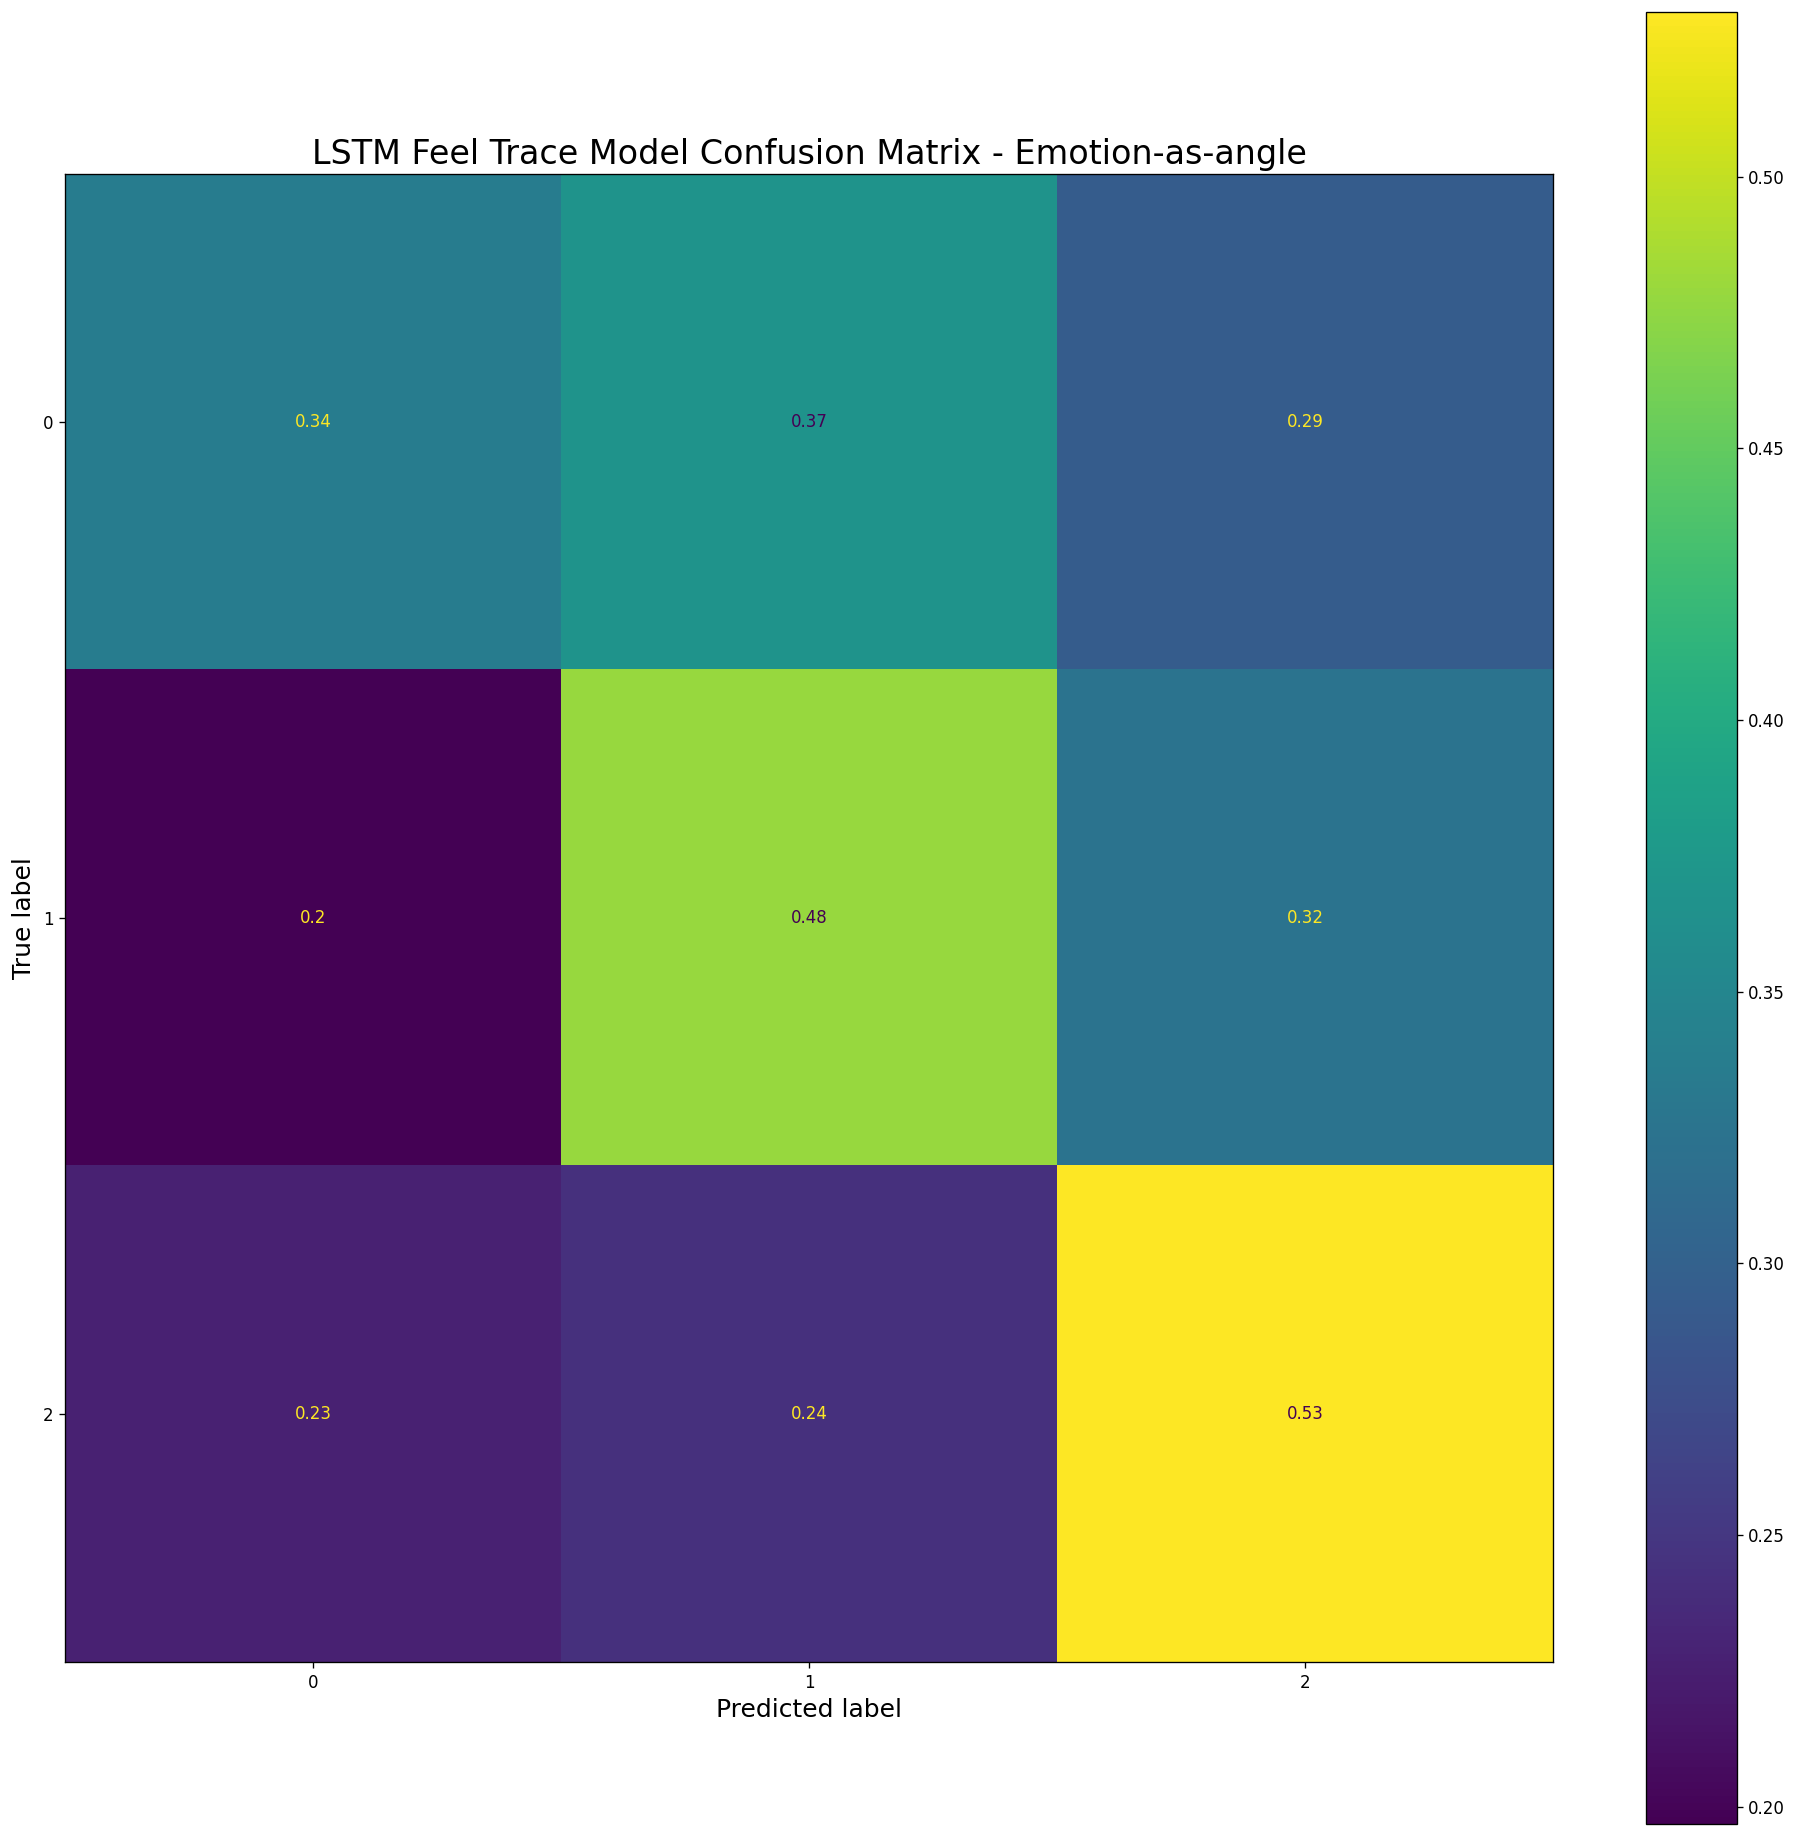

Training k=1
Training Classifier!
Train label distribution: [ 641 1502  526]


100%|██████████| 21/21 [00:03<00:00,  5.58it/s]


Epoch:1,
Train Loss:2.0721259117126465,
Train Accuracy:0.3323674366535605,
Train Recall: 0.331436748493419,
Train precision: 0.1453071946882958,
Train F1-Score:0.18262337565736342,


100%|██████████| 21/21 [00:03<00:00,  5.95it/s]


Epoch:2,
Train Loss:1.1210424900054932,
Train Accuracy:0.34868870139799035,
Train Recall: 0.3461245001710265,
Train precision: 0.2673165570490753,
Train F1-Score:0.2369345586734393,


100%|██████████| 21/21 [00:03<00:00,  5.55it/s]


Epoch:3,
Train Loss:1.1001830101013184,
Train Accuracy:0.3601565913062473,
Train Recall: 0.3604959752358107,
Train precision: 0.3216410561886115,
Train F1-Score:0.2939823692433496,


100%|██████████| 21/21 [00:03<00:00,  5.67it/s]


Epoch:4,
Train Loss:1.0797717571258545,
Train Accuracy:0.4163355996068152,
Train Recall: 0.41866089002450824,
Train precision: 0.4350691206461037,
Train F1-Score:0.39867983646289995,


100%|██████████| 21/21 [00:03<00:00,  5.90it/s]


Epoch:5,
Train Loss:1.0658965110778809,
Train Accuracy:0.42883764744429886,
Train Recall: 0.4260196217925798,
Train precision: 0.4315356808091005,
Train F1-Score:0.41157105909750996,


100%|██████████| 21/21 [00:03<00:00,  5.62it/s]


Epoch:6,
Train Loss:1.0545625686645508,
Train Accuracy:0.4456742846221057,
Train Recall: 0.44759642029396834,
Train precision: 0.4533179104610146,
Train F1-Score:0.4388227368814673,


100%|██████████| 21/21 [00:03<00:00,  5.68it/s]


Epoch:7,
Train Loss:1.0264554023742676,
Train Accuracy:0.47993460572302316,
Train Recall: 0.4793916145145517,
Train precision: 0.48280585005707327,
Train F1-Score:0.4688286151566005,


100%|██████████| 21/21 [00:03<00:00,  5.90it/s]


Epoch:8,
Train Loss:1.02144455909729,
Train Accuracy:0.47128249235474007,
Train Recall: 0.46930121689639476,
Train precision: 0.4851640305614802,
Train F1-Score:0.4558367632563088,


100%|██████████| 21/21 [00:03<00:00,  5.98it/s]


Epoch:9,
Train Loss:1.0059788227081299,
Train Accuracy:0.49693506989951947,
Train Recall: 0.5012197693893039,
Train precision: 0.5039159563468121,
Train F1-Score:0.49303391275402236,


100%|██████████| 21/21 [00:03<00:00,  5.93it/s]


Epoch:10,
Train Loss:1.0089117288589478,
Train Accuracy:0.501221876365225,
Train Recall: 0.5045002830331125,
Train precision: 0.5083465929662672,
Train F1-Score:0.4910293780622516,
Test label distribution: [160 376 132]
Precision: 0.3791922419084078
Recall: 0.37468300021491513
F1-Score: 0.34117301170550274
Base line F1-Score: 0.24010217113665389
Accuracy: 0.35778443113772457
Metrics:
              precision    recall  f1-score   support

           0       0.28      0.53      0.36       160
           1       0.66      0.31      0.42       376
           2       0.20      0.29      0.24       132

    accuracy                           0.36       668
   macro avg       0.38      0.37      0.34       668
weighted avg       0.48      0.36      0.37       668



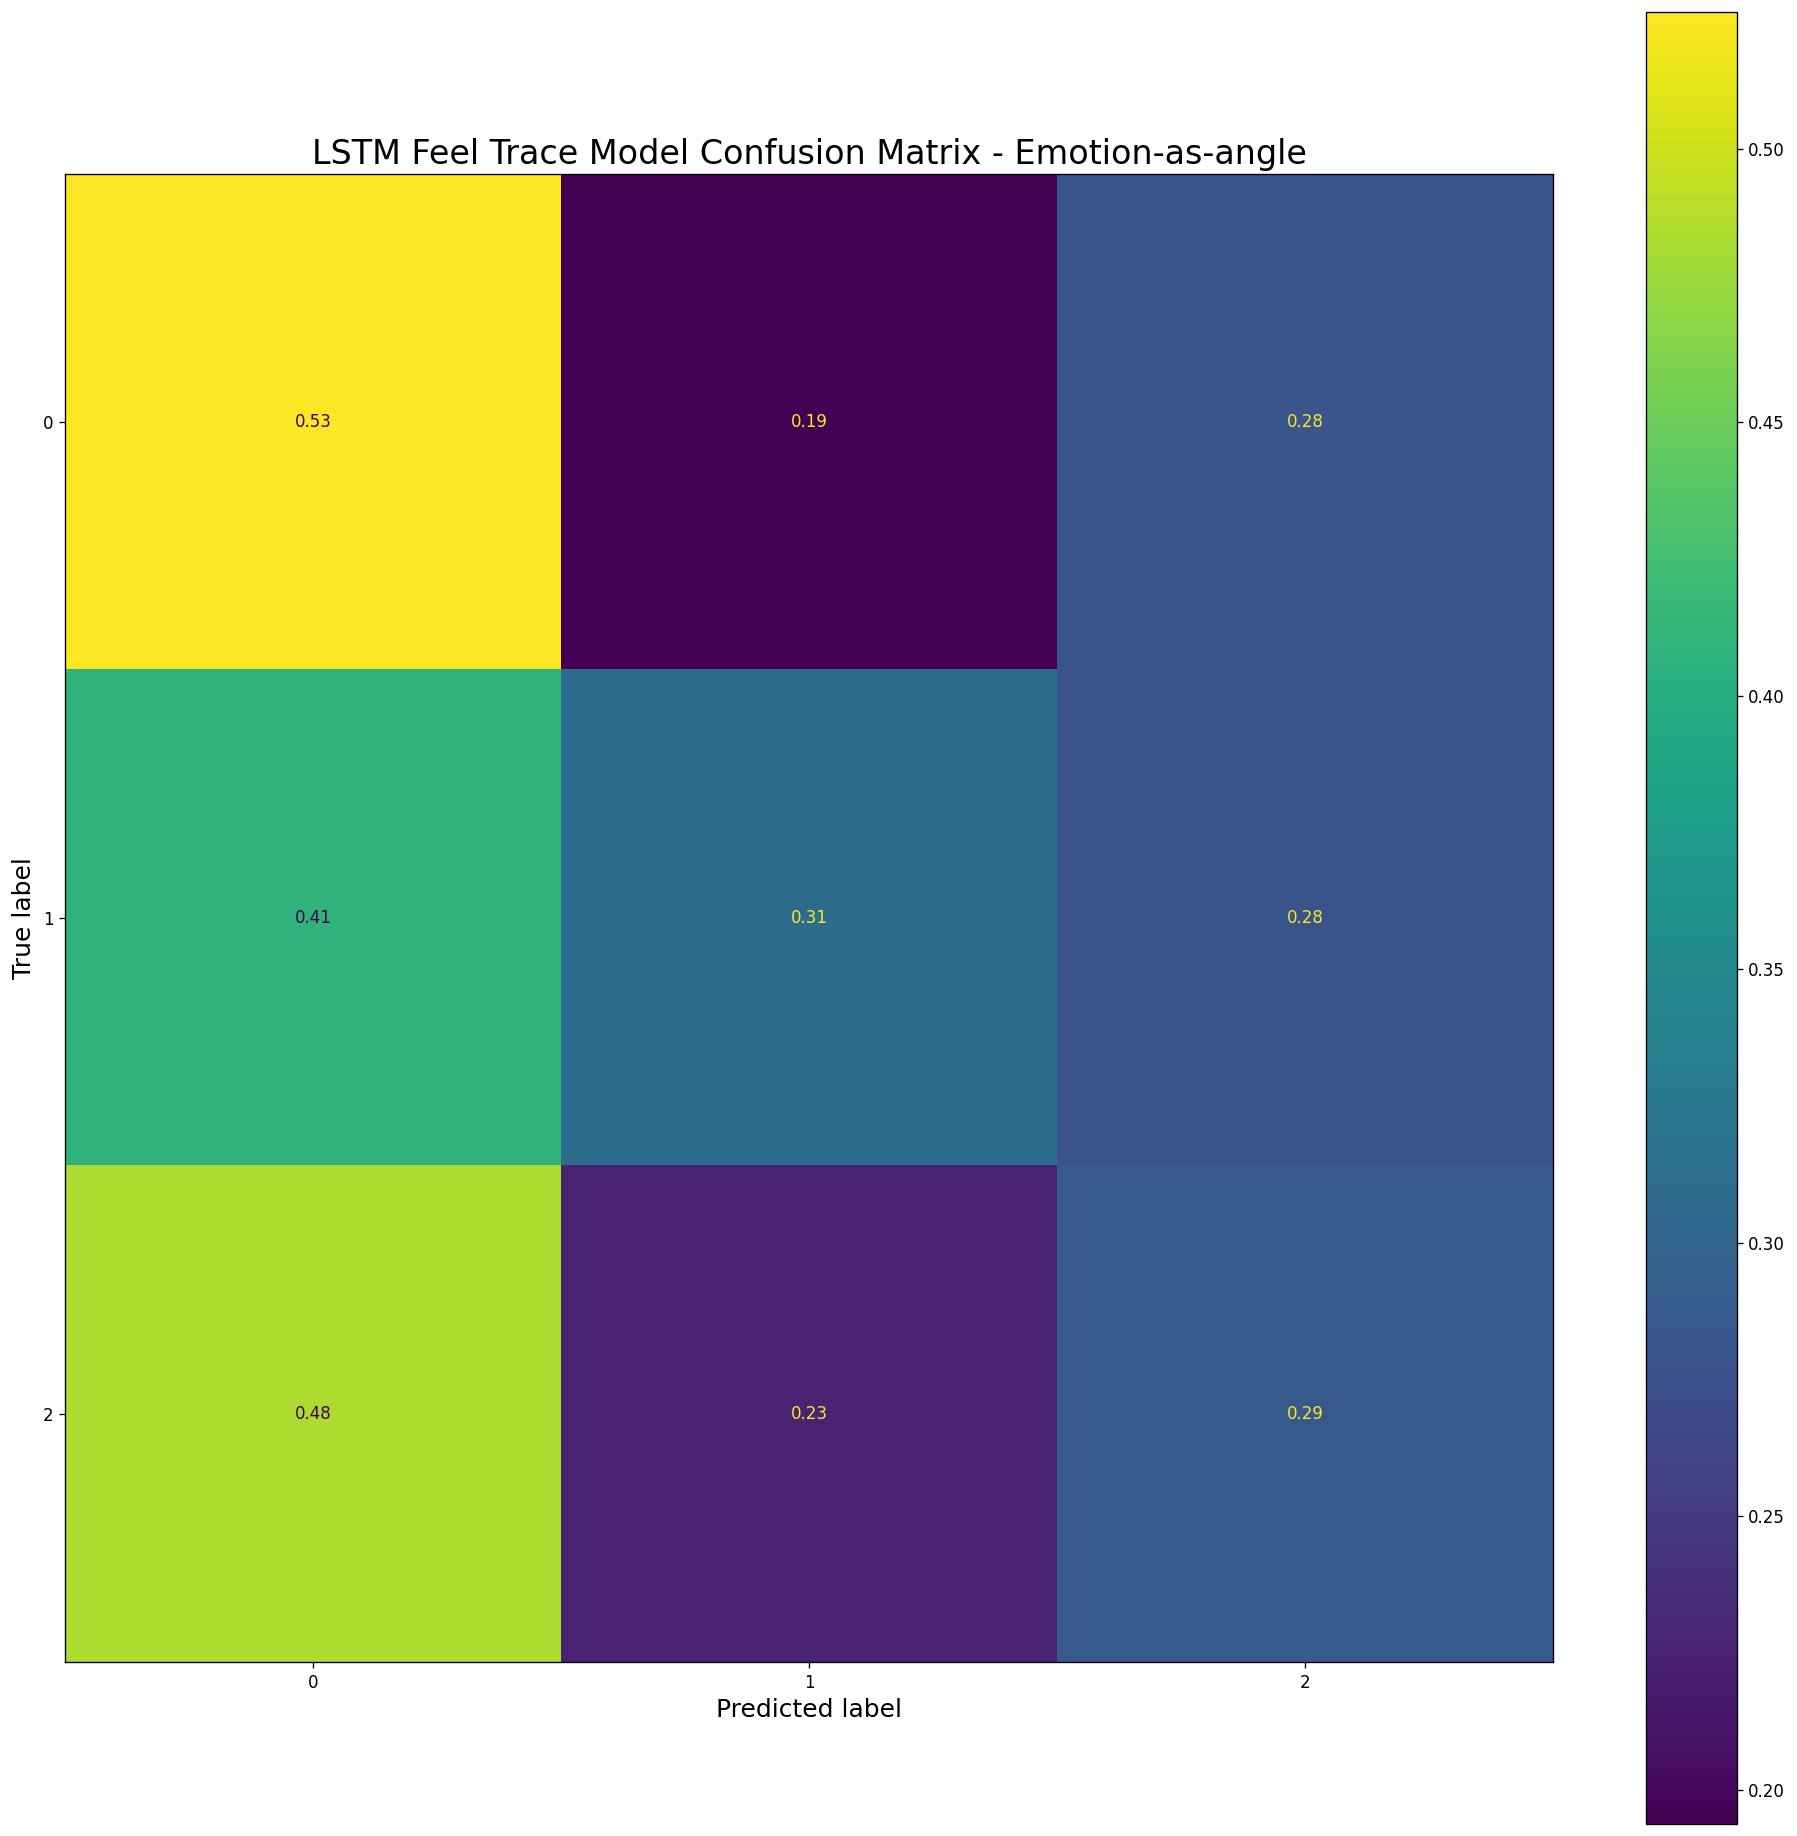

Training k=2
Training Classifier!
Train label distribution: [ 641 1502  527]


100%|██████████| 21/21 [00:03<00:00,  5.64it/s]


Epoch:1,
Train Loss:1.7459020614624023,
Train Accuracy:0.347362012987013,
Train Recall: 0.3416805751832853,
Train precision: 0.23984666963395598,
Train F1-Score:0.2242458613119252,


100%|██████████| 21/21 [00:04<00:00,  4.96it/s]


Epoch:2,
Train Loss:1.1059813499450684,
Train Accuracy:0.3623647186147186,
Train Recall: 0.3519063041974735,
Train precision: 0.3472981655130224,
Train F1-Score:0.29107902638742444,


100%|██████████| 21/21 [00:04<00:00,  4.90it/s]


Epoch:3,
Train Loss:1.0827127695083618,
Train Accuracy:0.39075351731601726,
Train Recall: 0.39832946198233854,
Train precision: 0.40429093215331935,
Train F1-Score:0.35513811891277103,


100%|██████████| 21/21 [00:04<00:00,  4.82it/s]


Epoch:4,
Train Loss:1.0477606058120728,
Train Accuracy:0.44109848484848485,
Train Recall: 0.43589809515894246,
Train precision: 0.45140264698500815,
Train F1-Score:0.4174975661775993,


100%|██████████| 21/21 [00:04<00:00,  5.13it/s]


Epoch:5,
Train Loss:1.0239225625991821,
Train Accuracy:0.4859983766233766,
Train Recall: 0.48867562290464245,
Train precision: 0.4882486532861086,
Train F1-Score:0.4808987776655436,


100%|██████████| 21/21 [00:04<00:00,  4.87it/s]


Epoch:6,
Train Loss:1.0073825120925903,
Train Accuracy:0.487790854978355,
Train Recall: 0.49247406597970667,
Train precision: 0.49604800039067887,
Train F1-Score:0.4789838724674271,


100%|██████████| 21/21 [00:04<00:00,  4.97it/s]


Epoch:7,
Train Loss:0.9899553656578064,
Train Accuracy:0.522747564935065,
Train Recall: 0.5241395034294472,
Train precision: 0.5290994917909466,
Train F1-Score:0.5139979227269431,


100%|██████████| 21/21 [00:03<00:00,  5.26it/s]


Epoch:8,
Train Loss:0.9791939854621887,
Train Accuracy:0.5256020021645021,
Train Recall: 0.525182933146532,
Train precision: 0.5304324061714041,
Train F1-Score:0.5204280260757361,


100%|██████████| 21/21 [00:03<00:00,  5.66it/s]


Epoch:9,
Train Loss:0.9653566479682922,
Train Accuracy:0.5296333874458875,
Train Recall: 0.5307162670602754,
Train precision: 0.5338857252659075,
Train F1-Score:0.5250323923067902,


100%|██████████| 21/21 [00:03<00:00,  6.21it/s]


Epoch:10,
Train Loss:0.9610557556152344,
Train Accuracy:0.5281385281385281,
Train Recall: 0.5265004878569488,
Train precision: 0.529411417228736,
Train F1-Score:0.5237858661384864,
Test label distribution: [160 376 131]
Precision: 0.4175034540365712
Recall: 0.4383269720101781
F1-Score: 0.40508210025063374
Base line F1-Score: 0.24033237456056245
Accuracy: 0.41829085457271364
Metrics:
              precision    recall  f1-score   support

           0       0.32      0.51      0.40       160
           1       0.64      0.38      0.47       376
           2       0.29      0.43      0.35       131

    accuracy                           0.42       667
   macro avg       0.42      0.44      0.41       667
weighted avg       0.49      0.42      0.43       667



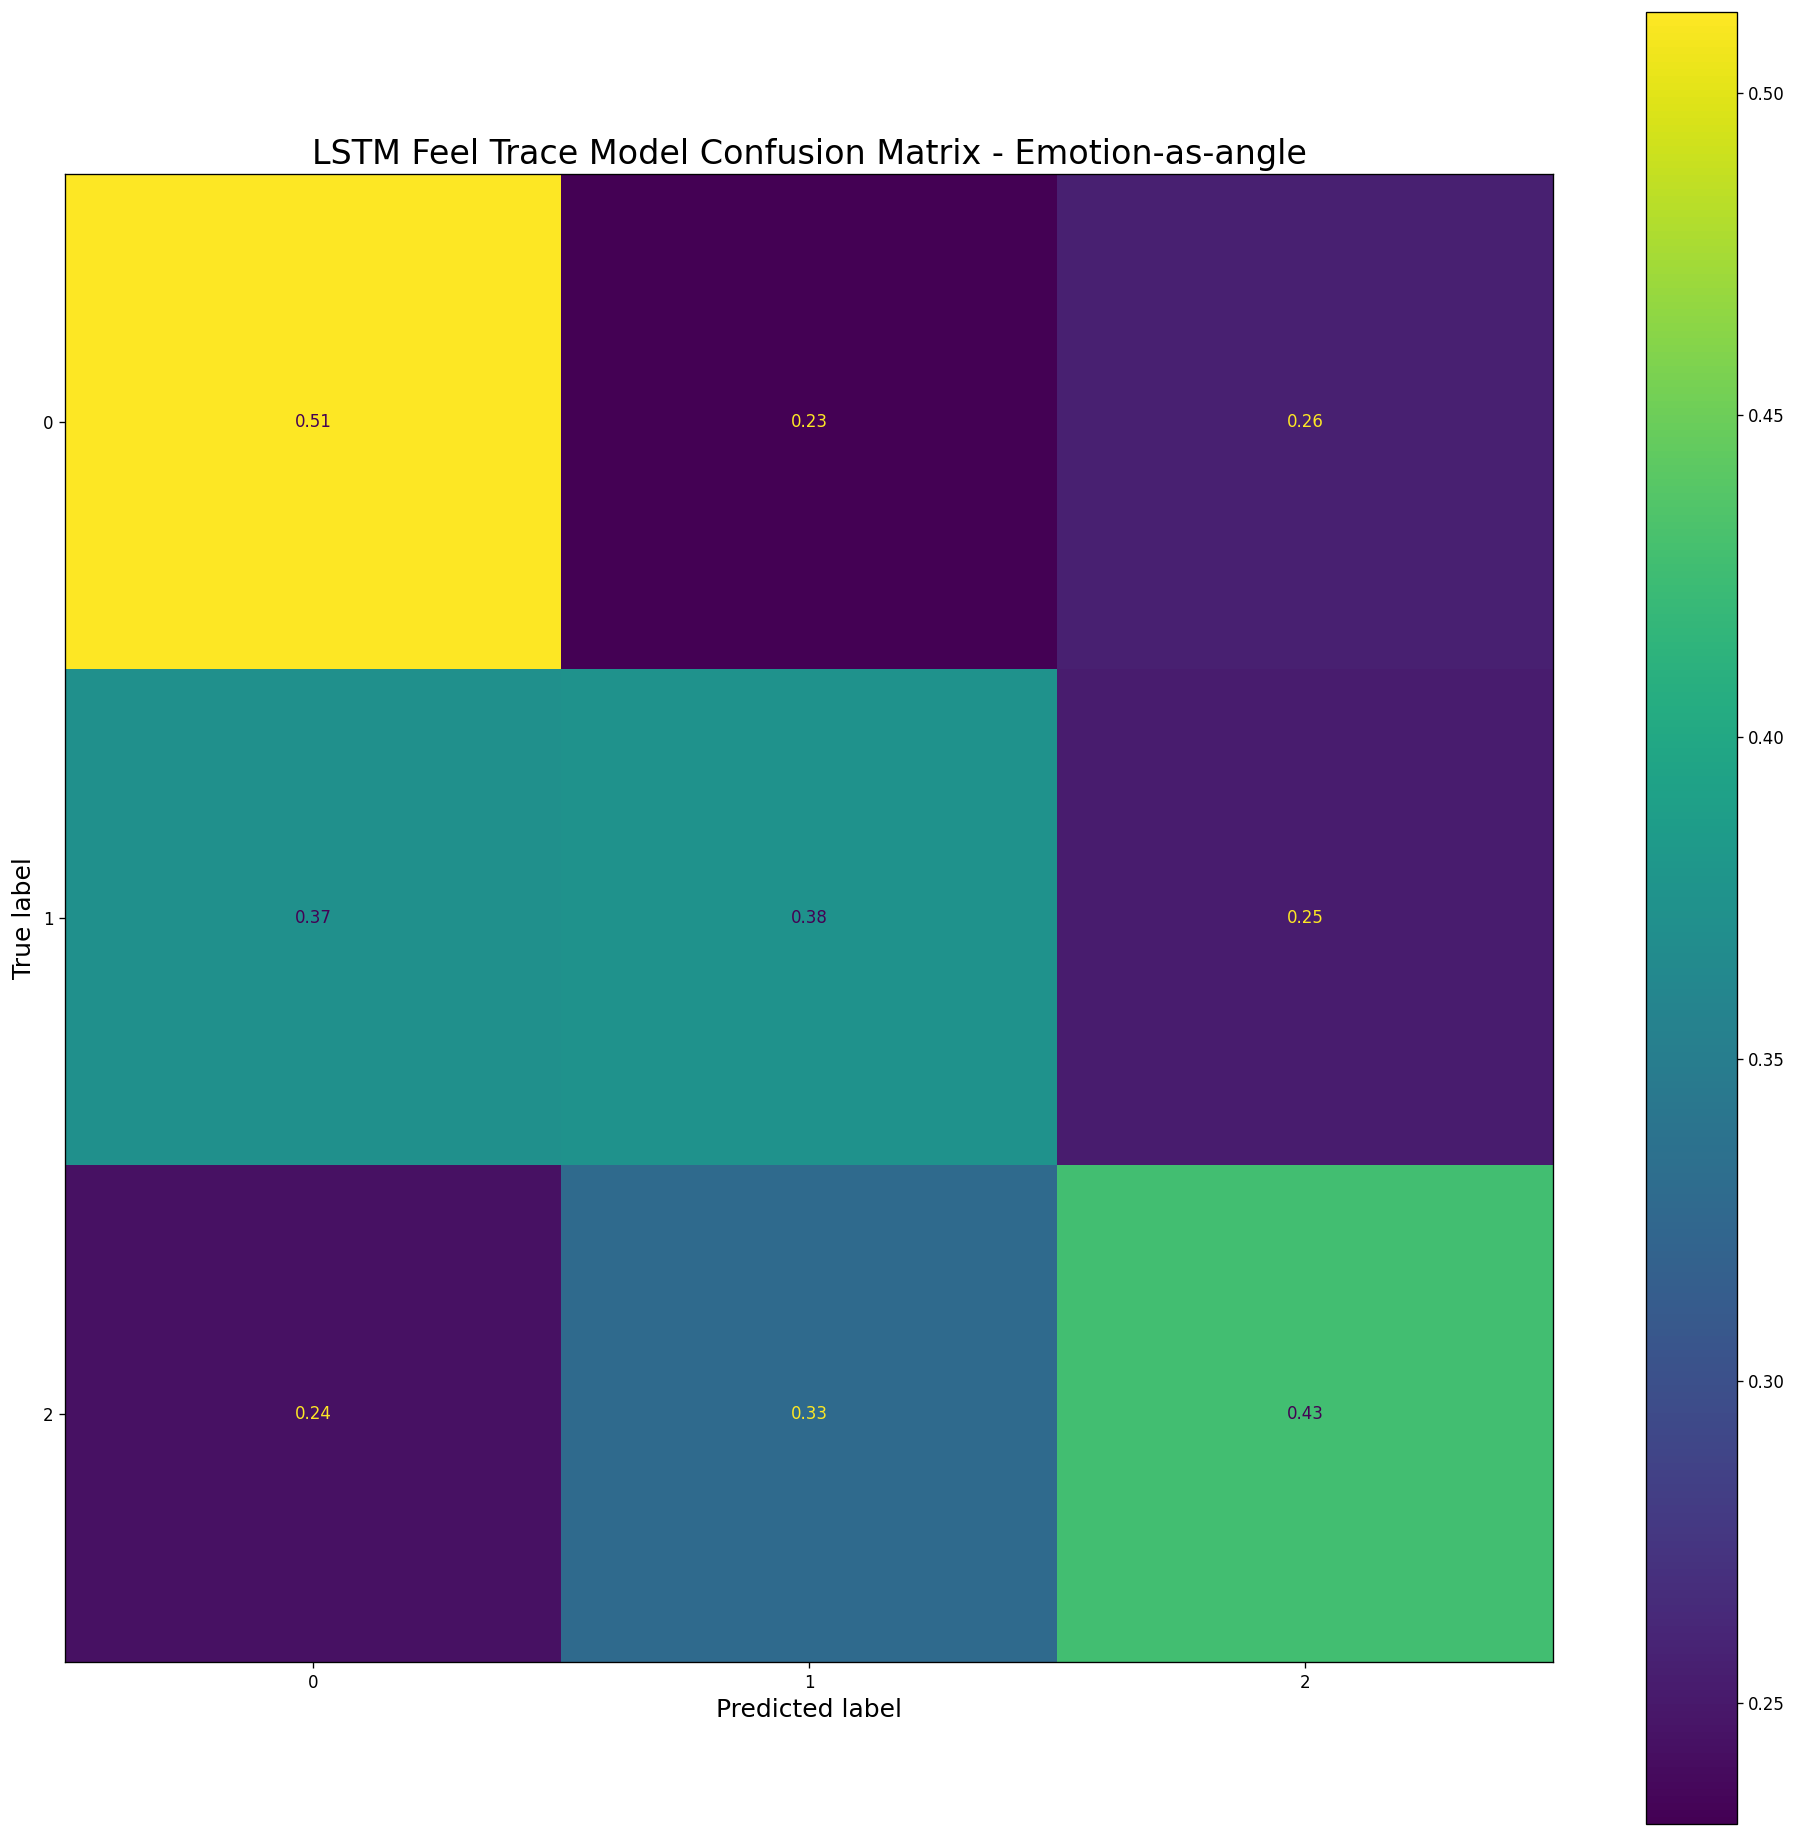

Training k=3
Training Classifier!
Train label distribution: [ 640 1503  527]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Epoch:1,
Train Loss:1.5838308334350586,
Train Accuracy:0.3396103896103896,
Train Recall: 0.3420663164599813,
Train precision: 0.2002285054642363,
Train F1-Score:0.20253151127073676,


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Epoch:2,
Train Loss:1.0957120656967163,
Train Accuracy:0.37593344155844155,
Train Recall: 0.37625183695151126,
Train precision: 0.313374445783669,
Train F1-Score:0.3021800364205724,


100%|██████████| 21/21 [00:04<00:00,  5.03it/s]


Epoch:3,
Train Loss:1.0805790424346924,
Train Accuracy:0.3973349567099567,
Train Recall: 0.40318073979092217,
Train precision: 0.41522055156711296,
Train F1-Score:0.3695193678104492,


100%|██████████| 21/21 [00:03<00:00,  5.86it/s]


Epoch:4,
Train Loss:1.06528639793396,
Train Accuracy:0.43118912337662335,
Train Recall: 0.4259235680645578,
Train precision: 0.4485098242925046,
Train F1-Score:0.40809360095731234,


100%|██████████| 21/21 [00:03<00:00,  5.72it/s]


Epoch:5,
Train Loss:1.0372182130813599,
Train Accuracy:0.4731601731601731,
Train Recall: 0.4758535116288866,
Train precision: 0.4819346948277838,
Train F1-Score:0.46430905635656555,


100%|██████████| 21/21 [00:04<00:00,  5.06it/s]


Epoch:6,
Train Loss:1.0299150943756104,
Train Accuracy:0.4636160714285714,
Train Recall: 0.4635580132917047,
Train precision: 0.47431217028922523,
Train F1-Score:0.451439759745398,


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Epoch:7,
Train Loss:1.0070545673370361,
Train Accuracy:0.5003720238095238,
Train Recall: 0.501383083715757,
Train precision: 0.5068028276207007,
Train F1-Score:0.49218255996506277,


100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch:8,
Train Loss:0.9803745746612549,
Train Accuracy:0.5218141233766234,
Train Recall: 0.5229749410311886,
Train precision: 0.5275496330081807,
Train F1-Score:0.5166573497232926,


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Epoch:9,
Train Loss:0.9634242057800293,
Train Accuracy:0.5306209415584415,
Train Recall: 0.5282995369742657,
Train precision: 0.5346533415660312,
Train F1-Score:0.522648359852291,


100%|██████████| 21/21 [00:04<00:00,  5.22it/s]


Epoch:10,
Train Loss:0.952027440071106,
Train Accuracy:0.5373782467532467,
Train Recall: 0.540216368243849,
Train precision: 0.5421139567243137,
Train F1-Score:0.5317201191531797,
Test label distribution: [161 375 131]
Precision: 0.4480944748581745
Recall: 0.46546948408747285
F1-Score: 0.44741238340553413
Base line F1-Score: 0.2399232245681382
Accuracy: 0.4752623688155922
Metrics:
              precision    recall  f1-score   support

           0       0.40      0.48      0.44       161
           1       0.65      0.49      0.56       375
           2       0.29      0.43      0.34       131

    accuracy                           0.48       667
   macro avg       0.45      0.47      0.45       667
weighted avg       0.52      0.48      0.49       667



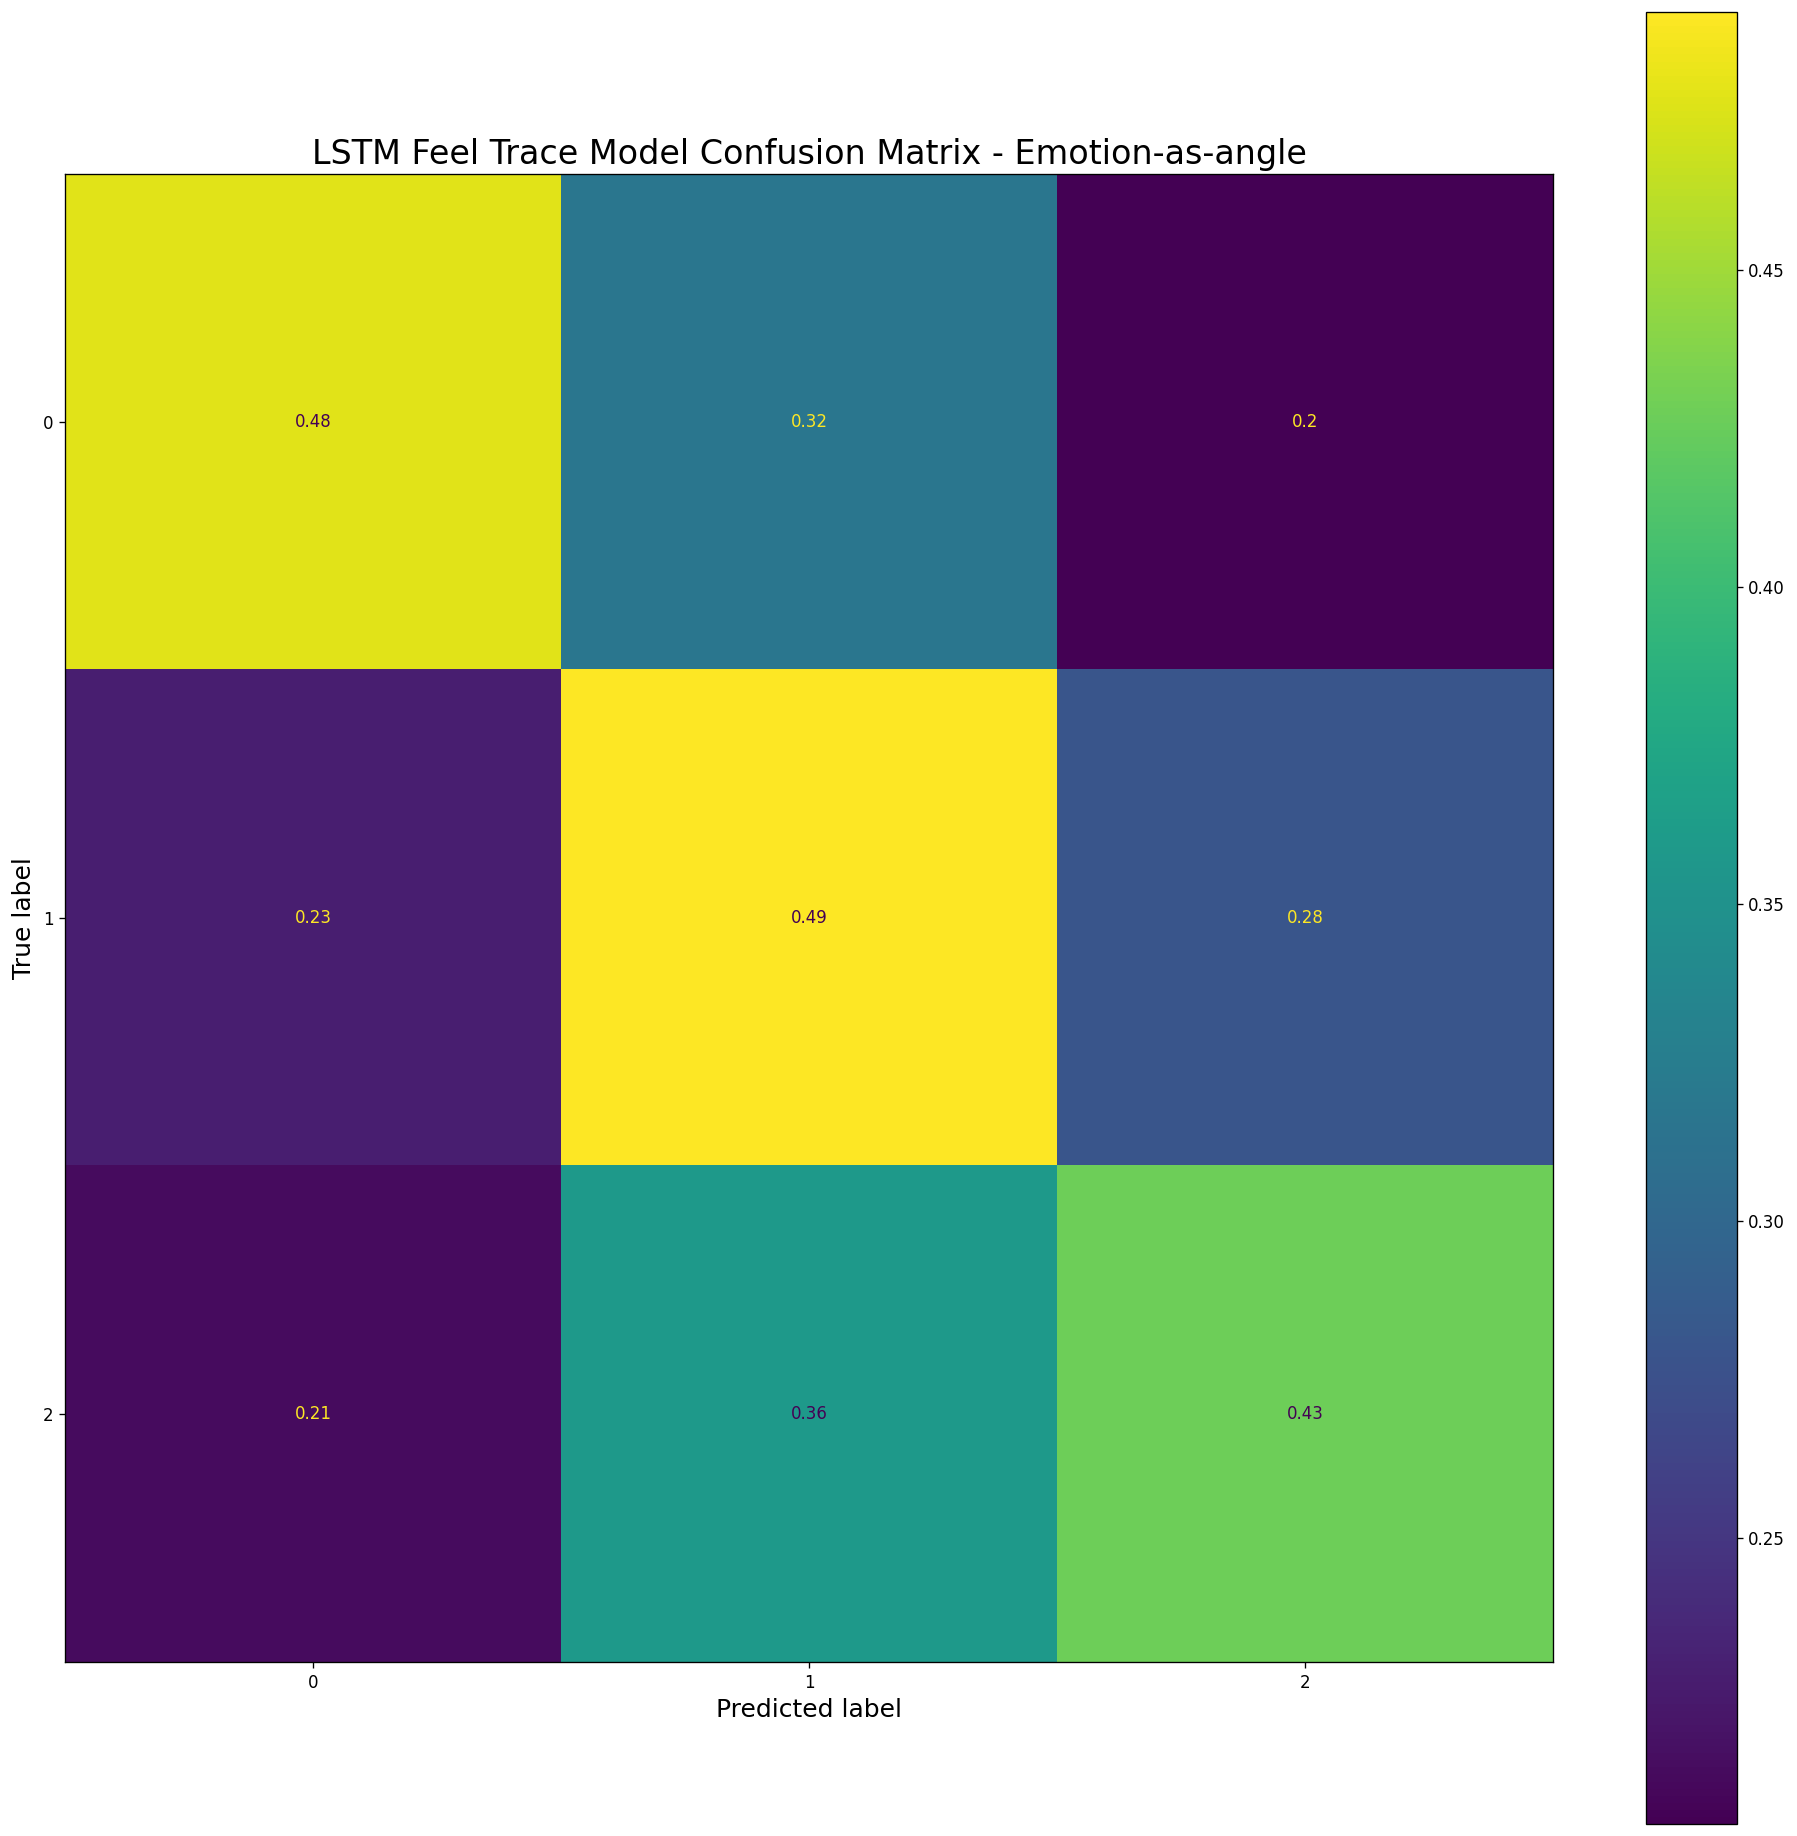

Training k=4
Training Classifier!
Train label distribution: [ 641 1503  526]


100%|██████████| 21/21 [00:03<00:00,  6.18it/s]


Epoch:1,
Train Loss:1.124439001083374,
Train Accuracy:0.35386904761904764,
Train Recall: 0.34578589389418835,
Train precision: 0.31232508155352573,
Train F1-Score:0.25457129543634216,


100%|██████████| 21/21 [00:04<00:00,  4.90it/s]


Epoch:2,
Train Loss:1.0700452327728271,
Train Accuracy:0.4219426406926407,
Train Recall: 0.4256805064938828,
Train precision: 0.4481427147632053,
Train F1-Score:0.4067895200221138,


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


Epoch:3,
Train Loss:1.0298410654067993,
Train Accuracy:0.4776176948051948,
Train Recall: 0.4754222523147287,
Train precision: 0.49215594909655785,
Train F1-Score:0.46622269478839035,


100%|██████████| 21/21 [00:04<00:00,  4.81it/s]


Epoch:4,
Train Loss:1.0168501138687134,
Train Accuracy:0.482027867965368,
Train Recall: 0.4802591726946286,
Train precision: 0.4997395137524924,
Train F1-Score:0.4682343795620585,


100%|██████████| 21/21 [00:04<00:00,  5.03it/s]


Epoch:5,
Train Loss:0.9856014251708984,
Train Accuracy:0.5136363636363637,
Train Recall: 0.5165312734572766,
Train precision: 0.5222433670910667,
Train F1-Score:0.5065449581987843,


100%|██████████| 21/21 [00:04<00:00,  4.70it/s]


Epoch:6,
Train Loss:0.9752007722854614,
Train Accuracy:0.5339082792207792,
Train Recall: 0.5367462017692818,
Train precision: 0.5535588215305927,
Train F1-Score:0.5254961044700348,


100%|██████████| 21/21 [00:04<00:00,  4.90it/s]


Epoch:7,
Train Loss:0.9525970220565796,
Train Accuracy:0.5535037878787878,
Train Recall: 0.556816911183365,
Train precision: 0.5662581288024454,
Train F1-Score:0.5496901791186014,


100%|██████████| 21/21 [00:04<00:00,  4.63it/s]


Epoch:8,
Train Loss:0.9190093278884888,
Train Accuracy:0.5610119047619048,
Train Recall: 0.5575247647740655,
Train precision: 0.5665719585675034,
Train F1-Score:0.5532451318002645,


100%|██████████| 21/21 [00:04<00:00,  5.06it/s]


Epoch:9,
Train Loss:0.9083473682403564,
Train Accuracy:0.5773065476190476,
Train Recall: 0.5758900956922753,
Train precision: 0.5799583171202999,
Train F1-Score:0.5716227107476891,


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Epoch:10,
Train Loss:0.8961816430091858,
Train Accuracy:0.5773674242424243,
Train Recall: 0.5791038205159542,
Train precision: 0.5841892355539436,
Train F1-Score:0.5721886096734075,
Test label distribution: [160 375 132]
Precision: 0.4209770637199665
Recall: 0.42519696969696974
F1-Score: 0.37912502244299473
Base line F1-Score: 0.2399232245681382
Accuracy: 0.3868065967016492
Metrics:
              precision    recall  f1-score   support

           0       0.30      0.56      0.39       160
           1       0.70      0.30      0.42       375
           2       0.27      0.41      0.33       132

    accuracy                           0.39       667
   macro avg       0.42      0.43      0.38       667
weighted avg       0.52      0.39      0.40       667



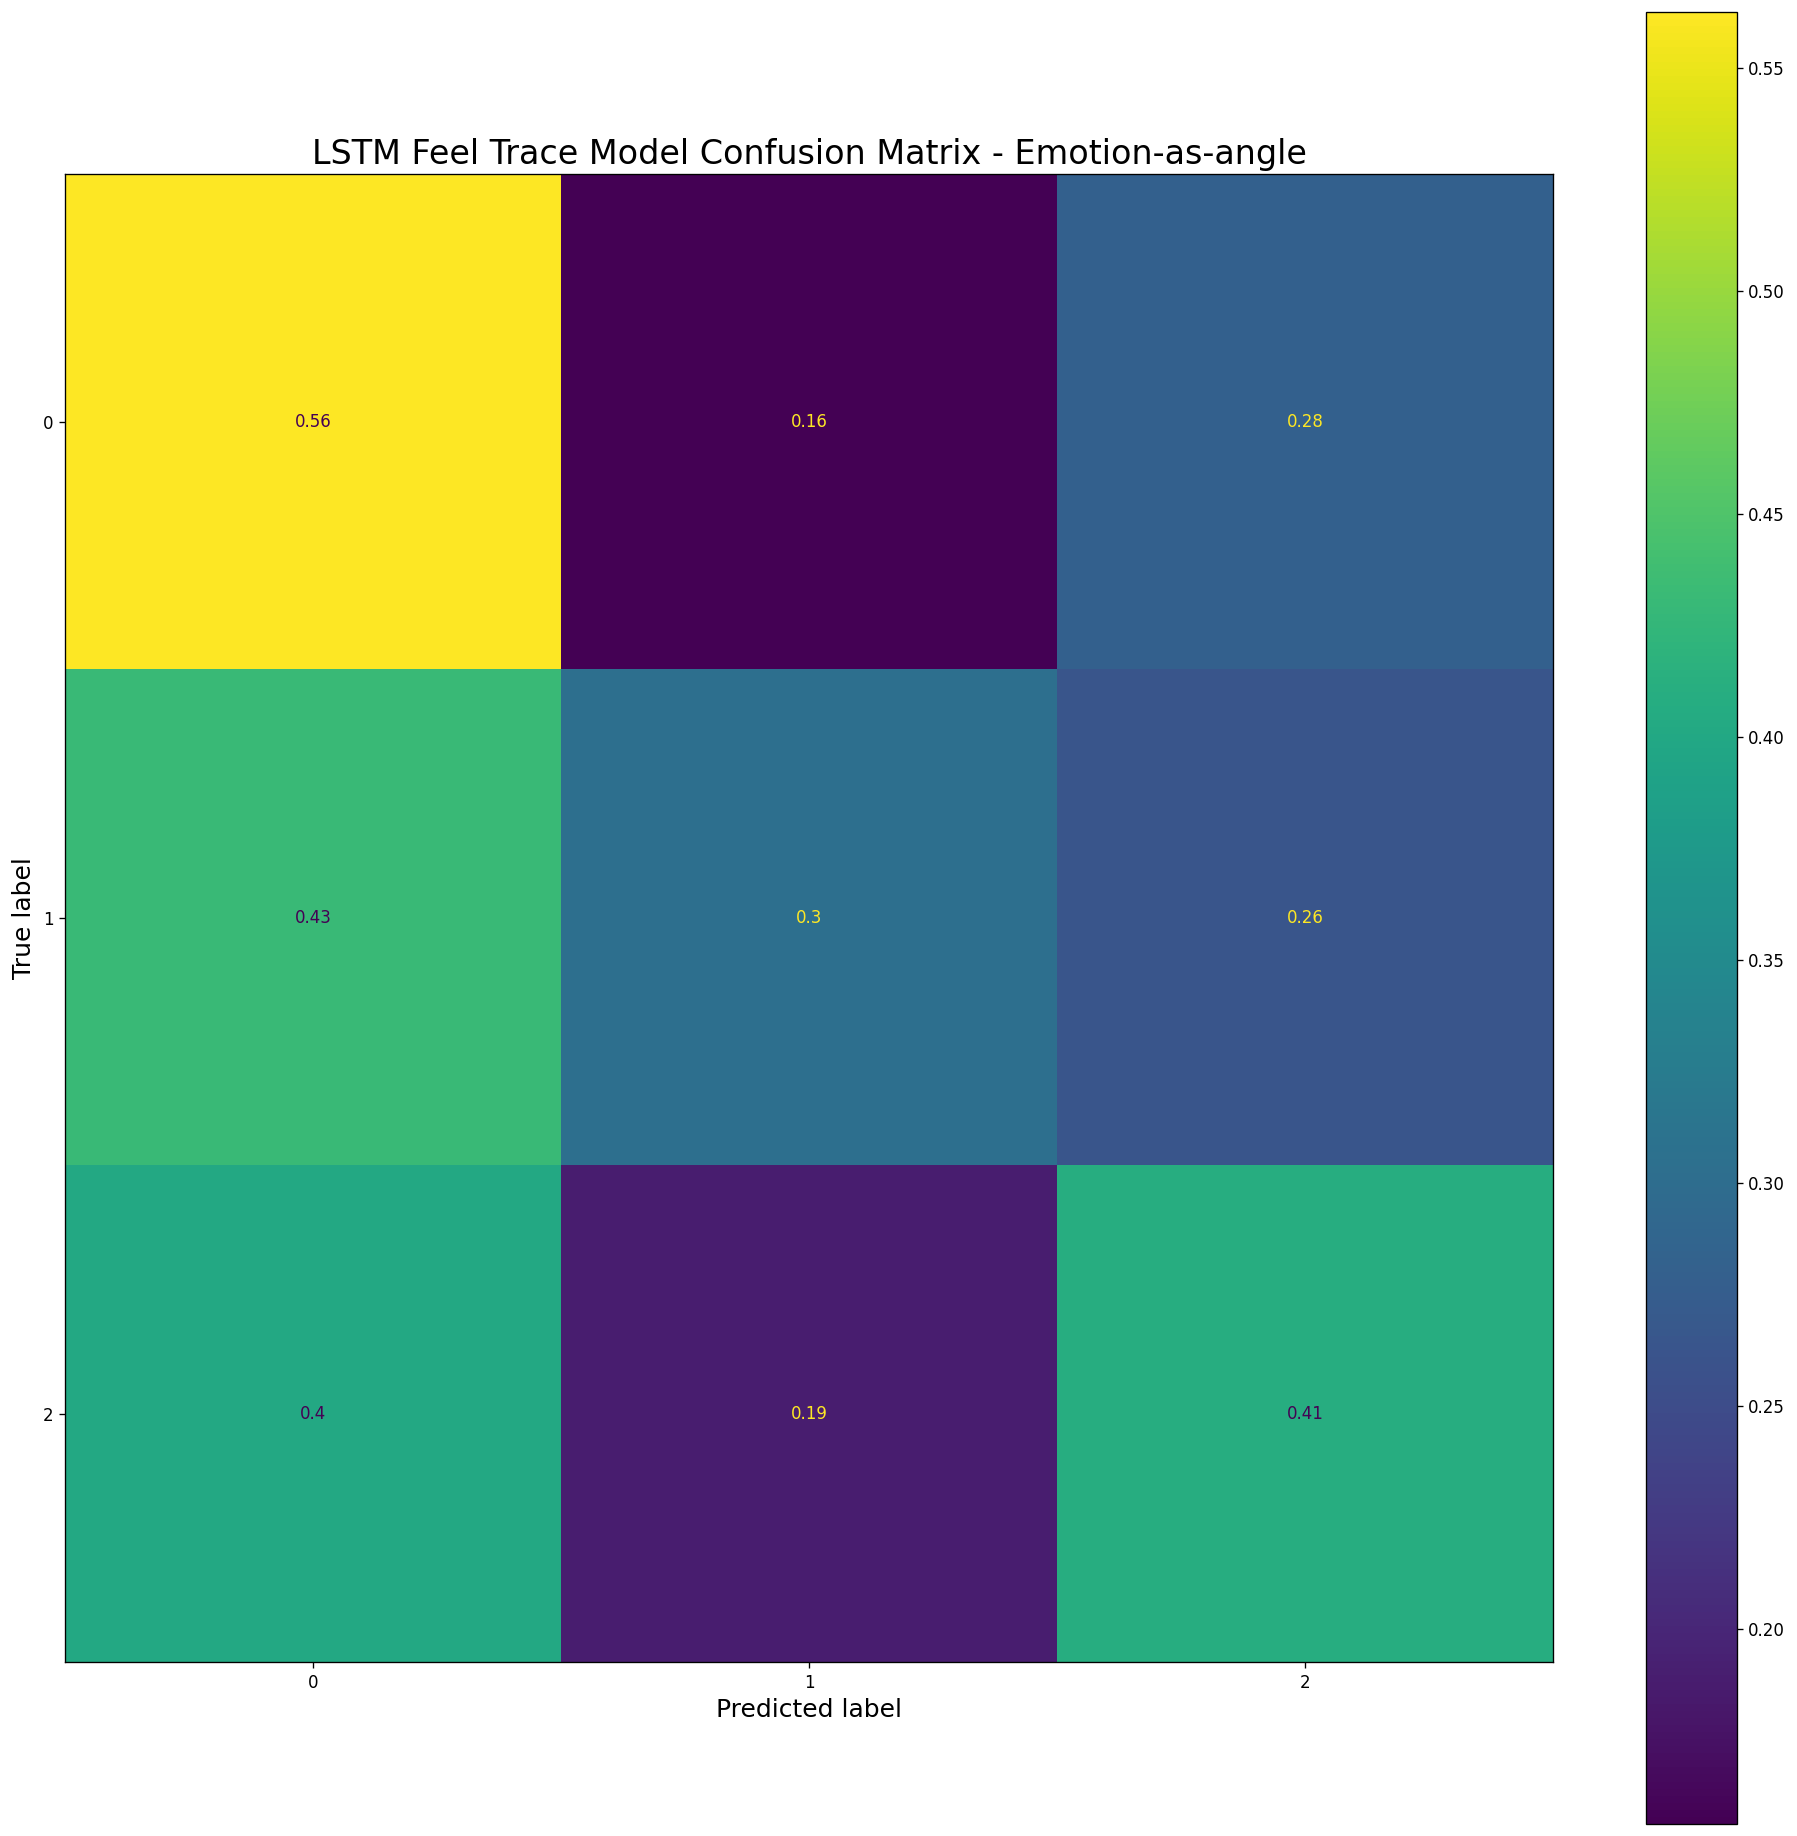

Accuracy, Average accuracy: [0.4488421448527831, 0.37468300021491513, 0.4383269720101781, 0.46546948408747285, 0.42519696969696974], 0.4305037141724638
F1-Score, Average F1-Score: [0.42446511718332314, 0.34117301170550274, 0.40508210025063374, 0.44741238340553413, 0.37912502244299473], 0.3994515269975977


In [18]:
k_acc = [] # accuracies for each fold
k_f1 = [] # f1 score for each fold

for cur_k in range(len(indices)):
    print(f"Training k={cur_k}")
    train_index, test_index = indices[cur_k]

    classifier_model = classifier(num_features=num_features, num_hidden=classifier_hidden, dropout=0.8, n_labels=num_classes)


    encoded_train_features = eeg_features[train_index]
    print('Training Classifier!')
    classifier_train_metrics = train_classifier(classifier_model, classifier_train_epochs, batch_size=128, learning_rate=classifier_learning_rate, features=encoded_train_features, labels=labels[train_index])


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_features, test_labels =  eeg_features[test_index], labels[test_index]
    print(f"Test label distribution: {np.bincount(test_labels, minlength=num_classes)}")
    encoded_test_features = test_features

    with torch.no_grad():
        classifier_model.eval()
        x_encoded  = torch.from_numpy(encoded_test_features).float().to(device)
        y = test_labels
        y_hat = classifier_model(x_encoded)
        y_hat = F.softmax(y_hat.detach(), dim=-1).cpu().numpy()
        preds = y_hat

    fig, axs = plt.subplots(figsize=(20,20), dpi=120)
    axs.set_title(f"LSTM Feel Trace Model Confusion Matrix - Emotion-as-{label_type}", fontsize=20)
    axs.set_xlabel("Predicted Label", fontsize=15)
    axs.set_ylabel("True Label", fontsize=15)


    prf = precision_recall_fscore_support(test_labels, np.array([x.argmax() for x in preds]), average='macro', zero_division=0)
    base_line = precision_recall_fscore_support(test_labels, np.array([1 for x in preds]), average='macro', zero_division=0)
    acc = np.mean(test_labels == np.array([x.argmax() for x in preds]))

    print(f"Precision: {prf[0]}")
    print(f"Recall: {prf[1]}")
    print(f"F1-Score: {prf[2]}")
    print(f"Base line F1-Score: {base_line[2]}")
    print(f"Accuracy: {acc}")
    print('Metrics:')
    print(classification_report(test_labels, np.array([x.argmax() for x in preds])))


    cm = confusion_matrix(test_labels, [x.argmax() for x in preds], labels=np.arange(num_classes), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
    
    acc = np.mean(cm.diagonal())
    k_acc.append(acc)
    k_f1.append(prf[2])


    disp.plot(ax=axs)
    plt.show()

print(f"Accuracy, Average accuracy: {k_acc}, {np.mean(k_acc)}")
print(f"F1-Score, Average F1-Score: {k_f1}, {np.mean(k_f1)}")